# Multi-Armed Bandit

In standard [multi-armed bandit](https://en.wikipedia.org/wiki/Multi-armed_bandit) problem we are given $k$ independent arms, each following [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution) with unknown probability of success $p_i$. We can pick only one arm at a time and collect the reward (0 or 1, since it's Bernoulli distributed). The problem is to do this optimally, such that we maximize the total collected rewards.

To implement this, we start with `BernoulliCounter` object that records *successes* and *failures* for each trial. For multi-armed bandit, we have $k$ arms, so we would be storing those objects in $k$-length list. We need to be able to `update` results by incrementing the counter for successes or failures, and we would like to be able to calculate success rate, i.e. `successes / (successes + failures)`.

In [1]:
using Distributions
import Base.rand

In [2]:
struct BernoulliCounter
    successes::Integer
    failures::Integer
    
    BernoulliCounter(successes = 0, failures = 0) = new(successes, failures)
end

function update(counter::BernoulliCounter, result::Bool)
   return BernoulliCounter(
        counter.successes + result,
        counter.failures + (1 - result)
    ) 
end

function success_rate(counter::BernoulliCounter)
    total = counter.successes + counter.failures
    if total == 0
        return 0
    else
        return counter.successes / total
    end
end

function success_rate(counters::Vector{BernoulliCounter})
    return map(counter -> success_rate(counter), counters)
end

success_rate (generic function with 2 methods)

## Multi-armed bandit algorithms and exploration-exploitation trade-off

Knowing nothing about the probabilities of success $p_i$, we could pick a random strategy, where at each step we would *explore* the reward distributions by picking arms uniformly at random. Alternatively, if we knew what was the best arm, we could just *exploit* by always pulling it, but without prior knowledge about the distribution of the rewards this won't work.

In [3]:
function explore(rewards::Vector{BernoulliCounter})
    n = length(rewards)
    return rand(1:n)
end

function exploit(rewards::Vector{BernoulliCounter})
    return argmax(success_rate(rewards))
end

exploit (generic function with 1 method)

### Exploration-only and explore-first algorithms

As said above, one solution could be to use *exploration-only*, but more optimal strategy is to *explore-first*, so that for $n$ rounds we *explore*, and then pick the arm with highest collected rewards and *exploit* it. This obviously leads to [*exploration-exploitation trade-off*](https://towardsdatascience.com/intuition-exploration-vs-exploitation-c645a1d37c7a), i.e. the longer we explore, the more often we pick sub-optimal arms (that give less rewards), but the better data we have to make decission in exploitation phase.

In [4]:
function explore_first(rewards::Vector{BernoulliCounter}, step::Integer, exploration_steps::Integer)
    if step > exploration_steps
        return exploit(rewards)
    else
        return explore(rewards)
    end
end

explore_first (generic function with 1 method)

### $\varepsilon$-greedy algorithm

We could also randomize between exploration and exploitation, choosing exploration with probability $\varepsilon$.

In [5]:
function epsilon_greedy(rewards::Vector{BernoulliCounter}, step::Integer, epsilon::Real)
    if rand() > epsilon
        return exploit(rewards)
    else
        return explore(rewards)
    end
end

epsilon_greedy (generic function with 1 method)

### Upper confidence bound (UCB) algorithm

Different approach was proposed in UCB algorithm, where we pick the arm that has highest average reward where we pick the $i$-th arm with highest average reward $\hat{Q}_i$, but correcting for the uncertanity of the arm $\hat{U}_i$

$$
\operatorname{arg\,max}_i\; \hat{Q}_i + \hat{U}_i
$$

This can be implemented as in [UCB1 algorithm](https://lilianweng.github.io/lil-log/2018/01/23/the-multi-armed-bandit-problem-and-its-solutions.html#upper-confidence-bounds), where uncertanity for the arm is based on how often the arm was picked in the past $n_i$

$$
\operatorname{arg\,max}_i\; \hat{Q}_i + \sqrt{\frac{2\ln t}{n_i}}
$$

where $t = \sum_i n_i$ is the total number of steps for all arms.

In [6]:
function ucb1(rewards::Vector{BernoulliCounter}, step::Integer)
    ucb = []
    for cnt in rewards
        Qi = success_rate(cnt)
        ni = cnt.successes + cnt.failures
        push!(ucb, Qi + sqrt((2 * log(step)) / ni))
    end
    return argmax(ucb)
end

ucb1 (generic function with 1 method)

### Bayesian UCB

UCB algorithm [can be improved](https://github.com/lilianweng/multi-armed-bandit/blob/master/solvers.py#L102) assuming a Bayesian model. We could assume that the rewards follow binomial distributions, and to estimate their 
probability of successes $p_i$ we assume beta priors. Since beta distribution is a conjugate prior for binomial, there is a closed-form for the posterior distribution. If for $i$-th arm we start with beta distribution with parameters $\alpha_i = \beta_i = 1$, than after observing a binary reward $r_i$, we can update the parameters to

$$\begin{align}
\alpha_i &\leftarrow \alpha_i + r_i \\
\beta_i &\leftarrow \beta_i + (1 - r_i)
\end{align}$$

So $\alpha_i$ is a posterior count of successes, and $\beta_i$ is a posterior count of failures. We assume that *a posteriori* probabilities $p_i$ follow beta distributions

$$
p_i \sim \mathsf{Beta}(\alpha_i, \beta_i)
$$


We could use mean $\mu_i$, and standard deviation $\sigma_i$ of the posterior distribution multiplied by a constant $c$, as estimates of the average reward $\hat{Q}_i$ and uncertanity $\hat{U}_i$ and maximize the UCB

$$
\operatorname{arg\,max}_i\; \mu_i + c \sigma_i
$$

In [7]:
function bayesian_ucb(rewards::Vector{BernoulliCounter}, step::Integer, c::Real)
    ucb = []
    for cnt in rewards
        dist = Beta(cnt.successes + 1, cnt.failures + 1)
        push!(ucb, mean(dist) + c * std(dist))
    end
    return argmax(ucb)
end

bayesian_ucb (generic function with 1 method)

### Thompson sampling

To allow for more exploration, instead of using upper confidence bound of the posterior distributions for the arms, we could sample from those distribtuions. In such case we sample from the posterior distributions of the *possible* reward probabilities $p_i$, rather than using fixed bounds given those distributions, as in bayesian UCB algorithm. 

In [8]:
function thompson_sampling(rewards::Vector{BernoulliCounter}, step::Integer)
    probs = []
    for cnt in rewards
        dist = Beta(cnt.successes + 1, cnt.failures + 1)
        push!(probs, rand(dist))
    end
    return argmax(probs)
end

thompson_sampling (generic function with 1 method)

In [9]:
"""
Given an algorithm for picking arm of multi-armed bandit, current iteration number, historical rewards,
and a function for collecting the reward for the picked arm, do one step of optimization. At each step 
update the historical rewards records.
"""
function bandit_step!(pick_arm::Function, step::Integer, rewards::Vector{BernoulliCounter}, collect_reward::Function)
    idx = pick_arm(rewards, step)
    rewards[idx] = update(rewards[idx], collect_reward(idx))
end

bandit_step!

## Simulation example

Let's compare the algorithms given simulated multi-armed bandit with several Bernoulli arms defined in `reward_distribution`. Each algorithm would run for `iters` number of iteration. Each would have access to same `rewards`. The algorithms would be compared to an orlacle, that *knows* the true probabilities of success for each arm, so can exploit this knowledge by always pulling the best arm.

In [10]:
using Plots
using Formatting
import Random

Random.seed!(42)

function init_counters(n)
    return [BernoulliCounter(0, 0) for _ in 1:n]
end

function successes(counters::Vector{BernoulliCounter})
    return map(counter -> counter.successes, counters)
end

successes (generic function with 1 method)

In [11]:
iters = 2000
reward_distribution = [Bernoulli(0.2), Bernoulli(0.5), Bernoulli(0.6)]
best_arm = argmax([dist.p for dist in reward_distribution])

samplers = [
    ("Pure exploration",      (r, i) -> explore(r),                               init_counters(length(reward_distribution))),
    ("Explore first 25%",     (r, i) -> explore_first(r, i, Int32(0.25 * iters)), init_counters(length(reward_distribution))),
    ("Explore first 50%",     (r, i) -> explore_first(r, i, Int32(0.5 * iters)),  init_counters(length(reward_distribution))),
    ("UCB1",                  ucb1,                                               init_counters(length(reward_distribution))),
    ("Epsilon greedy ε=0.25", (r, i) -> epsilon_greedy(r, i, 0.25),               init_counters(length(reward_distribution))),
    ("Epsilon greedy ε=0.5",  (r, i) -> epsilon_greedy(r, i, 0.5),                init_counters(length(reward_distribution))),
    ("Epsilon greedy ε=0.75", (r, i) -> epsilon_greedy(r, i, 0.75),               init_counters(length(reward_distribution))),
    ("Bayesian UCB c=3",      (r, i) -> bayesian_ucb(r, i, 3),                    init_counters(length(reward_distribution))),
    ("Thompson sampling",     thompson_sampling,                                  init_counters(length(reward_distribution))),
    ("Oracle (best arm)",     (r, i) -> best_arm,                                 init_counters(length(reward_distribution))),
]
success_rates = Array{Real}(undef, (length(samplers), iters, length(reward_distribution)))

for step in 1:iters
    # all algorithms have access to same rewards
    rewards = [rand(dist) for dist in reward_distribution]
    
    for (i, (name, algo, collected_rewards)) in enumerate(samplers)
        bandit_step!(algo, step, collected_rewards, idx -> rewards[idx])
        success_rates[i, step, :] = success_rate(collected_rewards)
    end
end

In [12]:
for (name, _, rewards) in samplers
    printfmt(
        "{: 25s} rewards={: 20s} total reward={: 10s} success rates={: 20s}\n",
        name,
        successes(rewards),
        sum(successes(rewards)),
        map(x -> round(x * 100, digits=1), success_rate(rewards))
    )
end

Pure exploration          rewards=[136, 337, 396]      total reward=869        success rates=[20.0, 50.4, 60.8]  
Explore first 25%         rewards=[33, 74, 978]        total reward=1085       success rates=[17.7, 47.4, 59.0]  
Explore first 50%         rewards=[82, 154, 793]       total reward=1029       success rates=[23.8, 47.5, 59.6]  
UCB1                      rewards=[18, 167, 919]       total reward=1104       success rates=[23.4, 47.4, 58.5]  
Epsilon greedy ε=0.25     rewards=[42, 95, 954]        total reward=1091       success rates=[21.1, 51.1, 59.1]  
Epsilon greedy ε=0.5      rewards=[70, 185, 778]       total reward=1033       success rates=[20.6, 49.2, 60.5]  
Epsilon greedy ε=0.75     rewards=[121, 248, 588]      total reward=957        success rates=[24.3, 51.1, 57.8]  
Bayesian UCB c=3          rewards=[0, 37, 1134]        total reward=1171       success rates=[0.0, 45.7, 59.2]   
Thompson sampling         rewards=[9, 16, 1148]        total reward=1173       success r

In above example, the best results (total rewards) were obtained when using Bayesian UCB, and Thompson sampling algorithms, that both were pretty close to the results obtained by the oracle. The worst results were obtained by algorithms that have spend most time on exploration, i.e. exploration-only, and $\varepsilon$-greedy with $\varepsilon=0.75$.

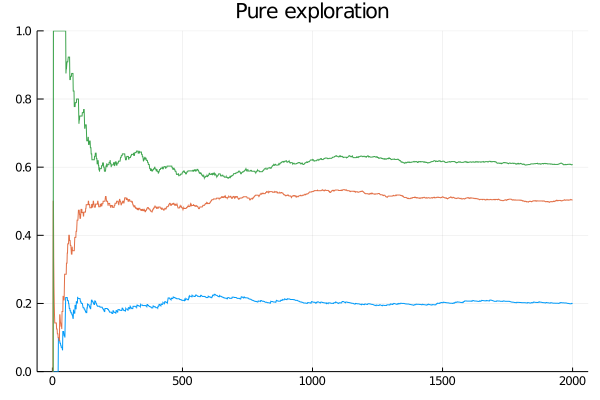

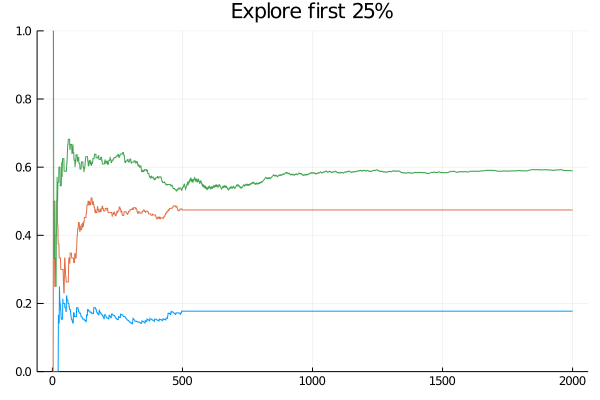

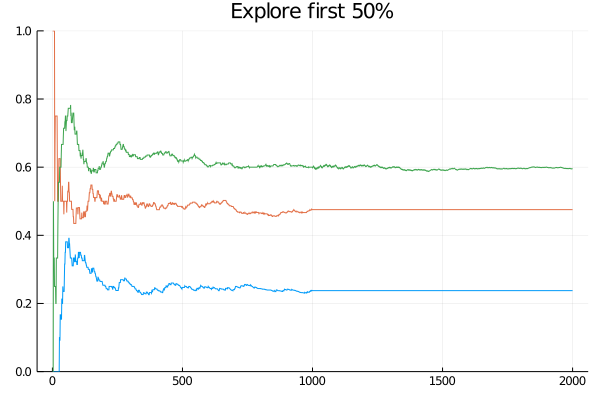

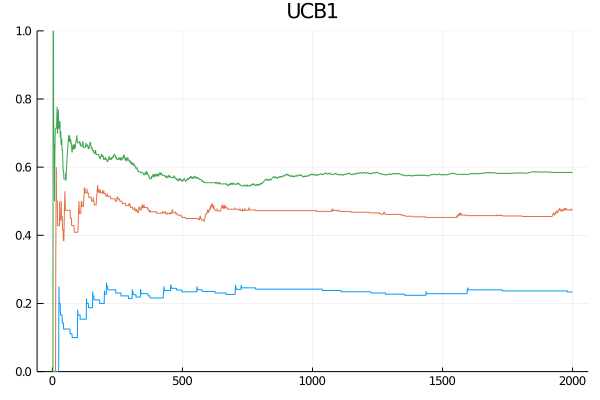

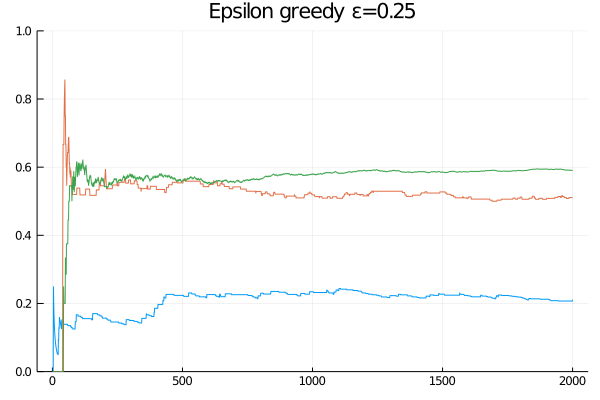

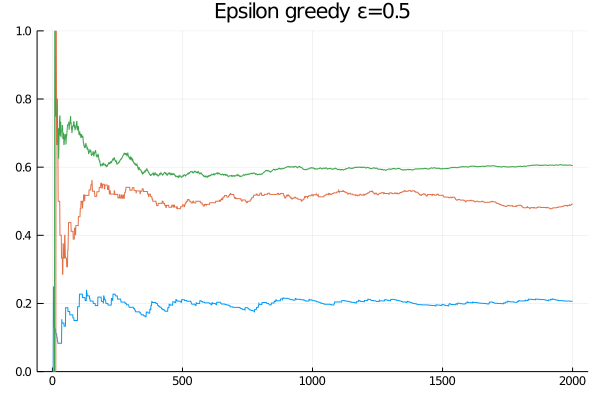

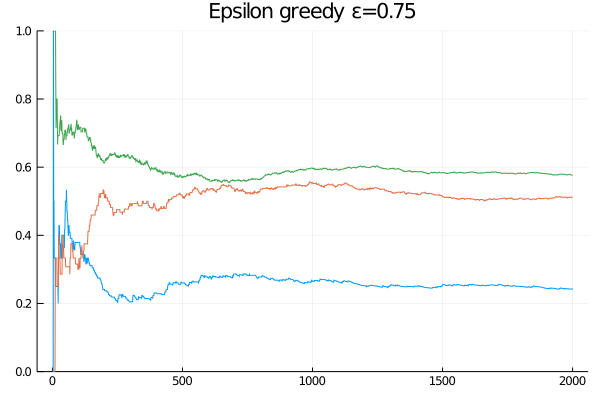

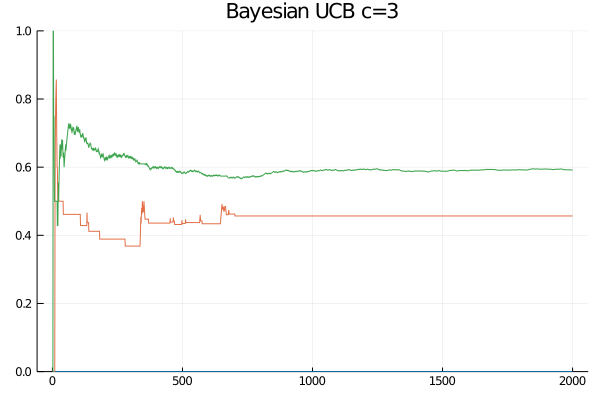

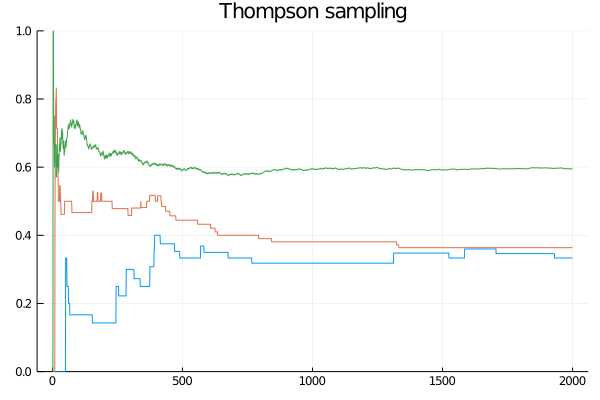

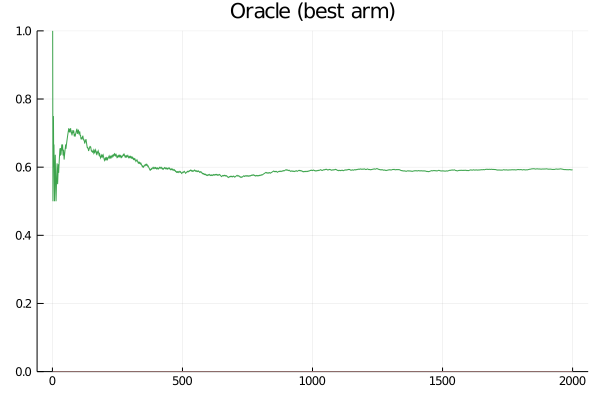

In [13]:
for (i, (name, _, rewards)) in enumerate(samplers)
    display(plot(success_rates[i, :, :], title=name, labels=false, ylim=(0, 1)))
end

## References 
Lydia Gu (2018) [A Tutorial on Thompson Sampling](https://www.youtube.com/watch?v=aWKeSvnTalE)  
Lilian Weng (Jan 23, 2018) [The Multi-Armed Bandit Problem and Its Solutions](https://lilianweng.github.io/lil-log/2018/01/23/the-multi-armed-bandit-problem-and-its-solutions.html#upper-confidence-bounds)  
Tony Pistilli (May 31, 2019) [Thompson Sampling For Multi-Armed Bandit Problems (Part 1)](https://towardsdatascience.com/hompson-sampling-for-multi-armed-bandit-problems-part-1-b750cbbdad34)  
https://towardsdatascience.com/solving-multiarmed-bandits-a-comparison-of-epsilon-greedy-and-thompson-sampling-d97167ca9a50  
Aleksandrs Slivkins (2019) [Introduction to Multi-Armed Bandits](https://arxiv.org/abs/1904.07272)  
Daniel J. Russo et al. [A Tutorial on Thompson Sampling](https://djrusso.github.io/RLCourse/papers/TS_Tutorial.pdf)  
Steven L. Scott (2010) [A modern Bayesian look at the multi-armed bandit](https://www.economics.uci.edu/~ivan/asmb.874.pdf)  